# SMS SPAM DETECTOR
This is a classification problem of supervised machine learning. The objective is to predict whether a given message is spam or not.

### Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings('ignore')

In [2]:
lemmatizer = WordNetLemmatizer()

### Loading data

In [3]:
data = pd.read_csv("SMSSpamCollection",sep="\t",names=["label","message"])

In [4]:
data.shape

(5572, 2)

In [5]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Checking whether our dataset is balanced or not 

ham     4825
spam     747
Name: label, dtype: int64


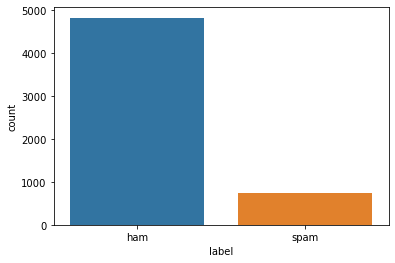

In [6]:
print(data['label'].value_counts())
sns.countplot(data['label'])
plt.show()

##### The above bar plot clearly states that our data is imbalanced

### Data cleaning and preprocessing

In [7]:
sentences=[]
for i in data['message']:
    line = re.sub("[^a-zA-Z]"," ",i)          #replacing all numbers and special chars into space
    
    line = line.lower()
    
    words = nltk.word_tokenize(line)
    
    stack=[]
    
    for word in words:
        if not word in stopwords.words("english"):
            stack.append(lemmatizer.lemmatize(word))
            
    line = " ".join(stack)
    sentences.append(line)

In [8]:
l=["a","b","c"]
print(" ".join(l))

a b c


In [9]:
sentences[0:5]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [10]:
data['lemmatized']=sentences

In [11]:
data.head()

,label,message,lemmatized
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


## Analysis on which words contributes most in identifying spam messages

In [12]:
df = data[data['label']=='spam']

In [13]:
count={}
for sent in df['lemmatized']:
    words = sent.split(" ")
    for word in words:
        if not word in count:
            count[word]=1
        else:
            count[word]=count.get(word,0)+1

In [14]:
sorted(count.items(),key = lambda x:x[1],reverse=True)[0:20]

[('call', 388),
 ('free', 228),
 ('u', 195),
 ('p', 180),
 ('txt', 170),
 ('text', 145),
 ('ur', 144),
 ('mobile', 142),
 ('stop', 128),
 ('claim', 115),
 ('c', 107),
 ('reply', 106),
 ('www', 98),
 ('prize', 97),
 ('min', 90),
 ('tone', 90),
 ('get', 86),
 ('uk', 77),
 ('cash', 76),
 ('win', 73)]

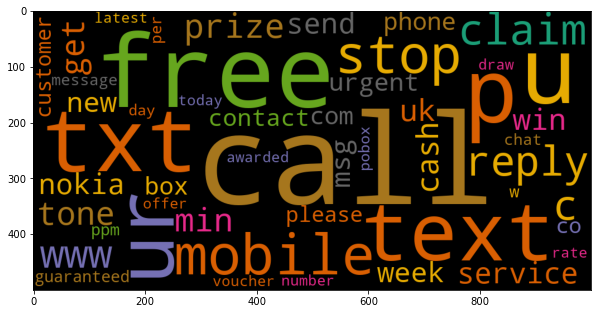

In [15]:
from wordcloud import WordCloud

plt.figure(figsize=(10,10))
wc = WordCloud(colormap="Dark2",max_words=50,width=1000,height=500,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(count)
plt.imshow(wc);

##### We can see words like free, claim, www, call, prize, cash, get are constributing the most in determining whether the message is spam or not

### Data Transformation : Converting sentences into vectors

In [16]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(sentences).toarray()

In [17]:
X.shape

(5572, 2500)

### Label encoding on target variable

In [18]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

In [19]:
y

array([0, 0, 1, ..., 0, 0, 0])

### Splitting data into train and test data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457, 2500)
(1115, 2500)
(4457,)
(1115,)


## Naive Bayes Classifier

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
nm = MultinomialNB()

In [25]:
nm.fit(x_train, y_train)

MultinomialNB()

### Confusing Matrix

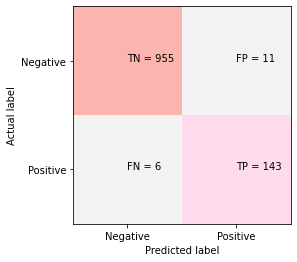

In [26]:
prediction = nm.predict(x_test)

cm = confusion_matrix(y_test,prediction)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Pastel1_r)
classname=['Negative','Positive']
tick_marks = np.arange(len(classname))
plt.xticks(tick_marks,classname)
plt.yticks(tick_marks,classname)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

##### TP - The sms is spam and model has predicted it as spam
##### TN - The sms is not spam and model has predicted it as not spam
##### FP - The sms is not spam and model has predicted it as spam
##### FN - The sms is spam and model has predicted it as not spam

### Model Evaluation

#### IF our dataset is imbalaned, then we can't really evaluate our model on basis of Accuracy. We have to check Precision Recall and F1 score


Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection. In email spam detection, a false positive means that an email that is non-spam (actual negative) has been identified as spam (predicted spam). The email user might lose important emails if the precision is not high for the spam detection model.

Recall is a good measure to determine, when there is a high cost associated with False Negative.
For instance, in fraud detection or sick patient detection. If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can be very bad for the bank.

In [27]:
prediction = nm.predict(x_test)
score = accuracy_score(y_test,prediction)*100
print("Accuracy of Naive Bayes Classifier->",np.round(score,2),"%")  
 
precision = (precision_score(y_test,prediction))*100
print("Precision score of Naive Bayes Classifier =>",np.round(precision,2))
nm_precision = np.round(precision,2)

recall = recall_score(y_test,prediction)*100
print("Recall score of Naive Bayes Classifier =>",np.round(recall,2))    
f1 = f1_score(y_test,prediction)*100
print("f1 score of Naive Bayes Classifier =>",np.round(f1,2))     

Accuracy of Naive Bayes Classifier-> 98.48 %
Precision score of Naive Bayes Classifier => 92.86
Recall score of Naive Bayes Classifier => 95.97
f1 score of Naive Bayes Classifier => 94.39


### ROC Curve
#### An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. 
#### The area under the curve of blue lines should be more

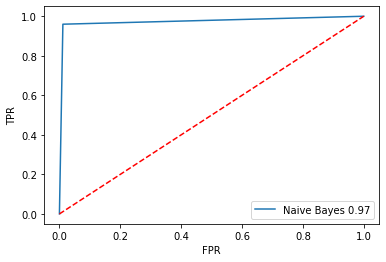

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test,prediction)
lr_roc_auc =roc_auc_score(y_test,prediction)
plt.figure()
plt.plot(fpr,tpr,label="Naive Bayes {}".format(round(lr_roc_auc,2)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right');

## Random Forest Classifier

Accuracy of Random Forest Classifier =>  97.85 %
Precision score of Random Forest Classifier => 99.21
Recall score of Random Forest Classifier => 84.56
f1 score of Random Forest Classifier => 91.3

Confusion Matrix => 


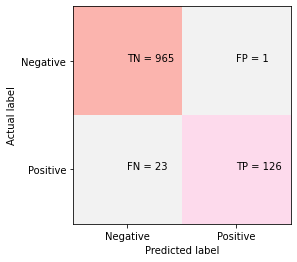

ROC Curve =>


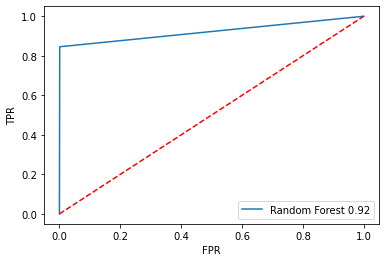

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=30)
rfc.fit(x_train, y_train)
prediction = rfc.predict(x_test)
print("Accuracy of Random Forest Classifier => ", np.round(accuracy_score(y_test,prediction)*100,2),"%")

precision = (precision_score(y_test,prediction))*100
print("Precision score of Random Forest Classifier =>",np.round(precision,2))  

rfc_precision = np.round(precision,2)

recall = recall_score(y_test,prediction)*100
print("Recall score of Random Forest Classifier =>",np.round(recall,2))    
f1 = f1_score(y_test,prediction)*100
print("f1 score of Random Forest Classifier =>",np.round(f1,2))     
print("")
print("Confusion Matrix => ")
cm = confusion_matrix(y_test,prediction)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Pastel1_r)
classname=['Negative','Positive']
tick_marks = np.arange(len(classname))
plt.xticks(tick_marks,classname)
plt.yticks(tick_marks,classname)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

print("ROC Curve =>")

fpr, tpr, threshold = roc_curve(y_test,prediction)
lr_roc_auc =roc_auc_score(y_test,prediction)
plt.figure()
plt.plot(fpr,tpr,label="Random Forest {}".format(round(lr_roc_auc,2)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.show()

## Decision Tree Classifier

Accuracy of Decision Tree Classifier =>  97.31 %
Precision score of Decision Tree Classifier => 92.81
Recall score of Decision Tree Classifier => 86.58
f1 score of Decision Tree Classifier => 89.58

Confusion Matrix => 


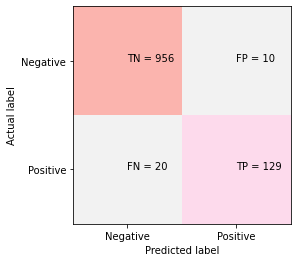

ROC Curve =>


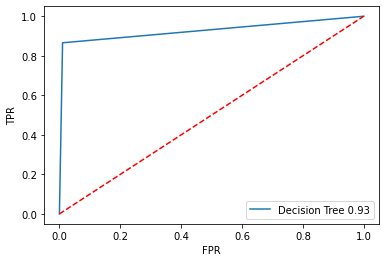

In [30]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
prediction = dtc.predict(x_test)
print("Accuracy of Decision Tree Classifier => ", np.round(accuracy_score(y_test,prediction)*100,2),"%")

precision = (precision_score(y_test,prediction))*100
print("Precision score of Decision Tree Classifier =>",np.round(precision,2))    
dtc_precision = np.round(precision,2)


recall = recall_score(y_test,prediction)*100
print("Recall score of Decision Tree Classifier =>",np.round(recall,2))    
f1 = f1_score(y_test,prediction)*100
print("f1 score of Decision Tree Classifier =>",np.round(f1,2))     
print("")
print("Confusion Matrix => ")

cm = confusion_matrix(y_test,prediction)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Pastel1_r)
classname=['Negative','Positive']
tick_marks = np.arange(len(classname))
plt.xticks(tick_marks,classname)
plt.yticks(tick_marks,classname)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
s = [['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

print("ROC Curve =>")
fpr, tpr, threshold = roc_curve(y_test,prediction)
lr_roc_auc =roc_auc_score(y_test,prediction)
plt.figure()
plt.plot(fpr,tpr,label="Decision Tree {}".format(round(lr_roc_auc,2)))
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.show()

## Conclusion

### Since this is sms spam classifier, there is high cost for False Positives. We can use precision score in order to determine which model to choose.


In [31]:
pd.DataFrame({'Classifier':['Naive Bayes','Random Forest','Decision Tree'],'Precision score':[nm_precision,rfc_precision,
                                                                                            dtc_precision]})

,Classifier,Precision score
0,Naive Bayes,92.86
1,Random Forest,99.21
2,Decision Tree,92.81


### Since, the precision score for random forest is highest. We will select random forest model for deployment.

In [32]:
import pickle

In [33]:
pickle.dump(rfc,open("model.pkl","wb"))

In [34]:
pickle.dump(cv,open("cv_transform.pkl","wb"))